In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

/Users/miracl6/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


sales.csv   - Данные по продажам за ноябрь 2015 г. в детализации День – Магазин – Товар - Сумма_Продаж

txn.csv     - Данные по продажам за период [2015-10-01, 2015-11-29] в детализации День – Магазин – Товар – Чек - Сумма_Продаж.

art.csv     - Справочник товаров

store.csv   - Справочник магазинов

## Задание 3.

### Спрогнозировать данные за 2015-11-30. Рассчитать показатели из п.1 за этот день.

Вычислим те же самые показатели по мазагинам за все время, что и в первом задании

In [2]:
art = pd.read_csv('art.csv', sep=';')
sales = pd.read_csv('sales.csv', sep=';')
store = pd.read_csv('store.csv', sep=';')
txn = pd.read_csv('txn.csv', sep=';')

In [3]:
#Преобразование строки c ценой в вещественное значение
txn['SALES'] = txn['SALES'].apply(lambda x: float(x.replace(',','.')))

In [4]:
#вычисление суммы чека по 1 магазину
txn_sum = txn.groupby('TXN')['SALES'].sum().reset_index().rename(columns={'SALES':'sum_price_txn'})
txn = pd.merge(txn, txn_sum, how='left', on='TXN')

Средняя цена чека на 1 магазин за октябрь и ноябрь

In [5]:
txn_price_mean = txn[['STORE','TXN','sum_price_txn']].drop_duplicates()
txn_price_mean =  txn.groupby('STORE')['sum_price_txn'].mean().reset_index()
txn_price_mean.head()

,STORE,sum_price_txn
0,956,427.167833
1,958,493.050574
2,961,562.129233
3,974,499.037848
4,980,470.808541


Среднее кол-во чеков на 1 магазин за октябрь и ноябрь

In [6]:
txn_count_mean = txn[['STORE','TXN','DAY']].drop_duplicates()
txn_count_mean = txn_count_mean.groupby(['STORE','DAY'])['TXN'].count().reset_index()
txn_count_mean = txn_count_mean.groupby('STORE')['TXN'].mean().round().reset_index()
txn_count_mean.head()

,STORE,TXN
0,956,561.0
1,958,475.0
2,961,428.0
3,974,264.0
4,980,244.0


Средние продажи на 1 магазин за октябрь и ноябрь

In [7]:
txn_art_mean = txn[['STORE','ART','TXN','DAY','TIME']].drop_duplicates()
txn_art_mean = txn_art_mean.groupby(['STORE','DAY'])['ART'].count().reset_index()
txn_art_mean = txn_art_mean.groupby('STORE')['ART'].mean().round().reset_index()
txn_art_mean.head()

,STORE,ART
0,956,2225.0
1,958,2138.0
2,961,2197.0
3,974,1176.0
4,980,1020.0


Для начала, спрогнозируем среднюю цену чека за 1 день по 1 магазину. Перед эти получим таблицу распредления средней цены чека по дням.

In [8]:
store_mean_txn = txn[txn['STORE']==956].groupby(['STORE','DAY'])['sum_price_txn'].mean().reset_index()
store_mean_txn.head()

,STORE,DAY,sum_price_txn
0,956,2015-10-01,362.784102
1,956,2015-10-02,407.745880
2,956,2015-10-03,413.477701
3,956,2015-10-04,409.833231
4,956,2015-10-05,351.783316


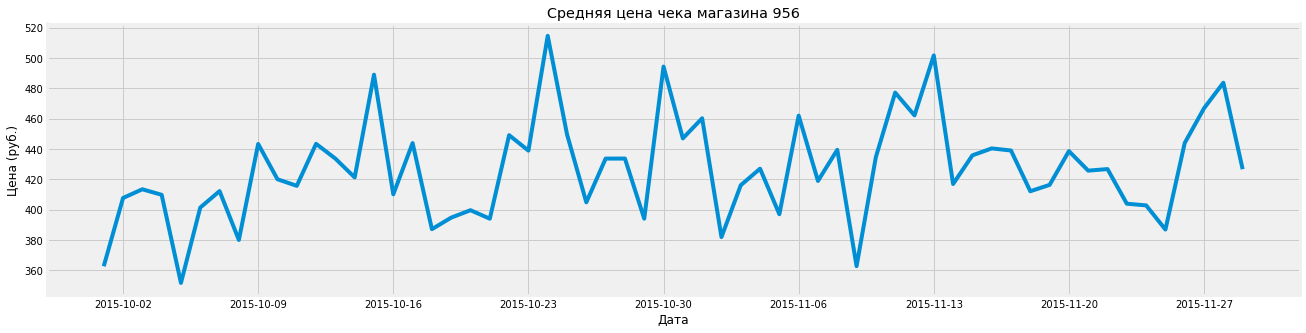

In [9]:
plt.figure(figsize=(20, 5))
plt.plot(pd.to_datetime(store_mean_txn['DAY']), store_mean_txn['sum_price_txn'])
plt.title('Средняя цена чека магазина 956')
plt.xlabel('Дата')
plt.ylabel('Цена (руб.)')
plt.show()

Воспользуемся методом декомпозиции временных рядов, который позволяет разложить наши временные ряды на три различных компонента: тренд, сезонность и шум

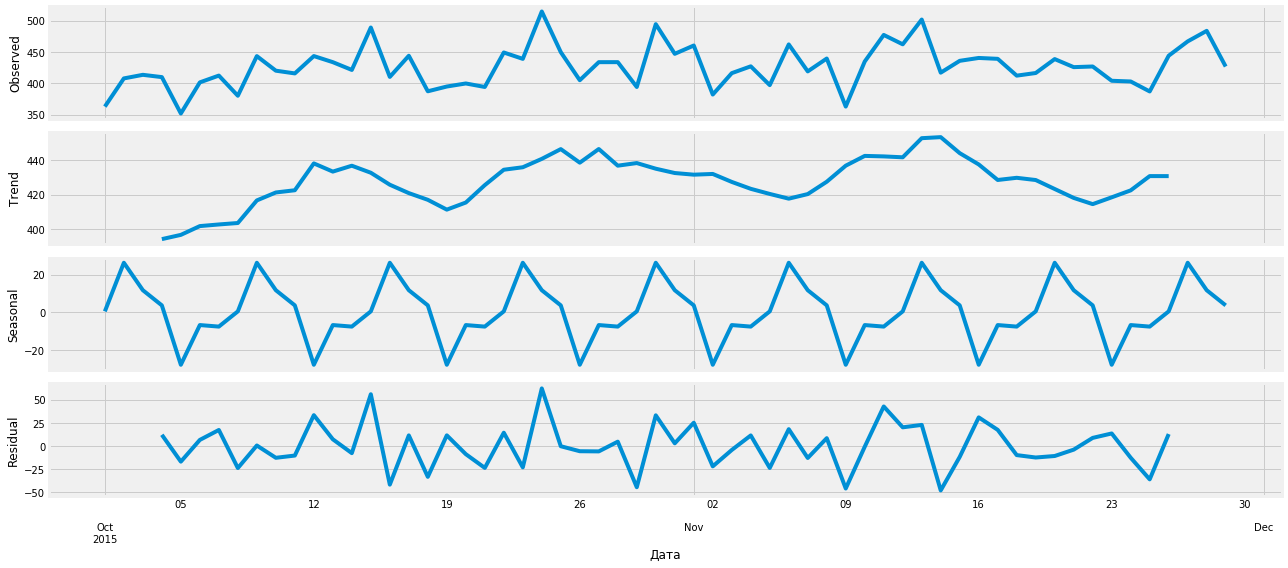

In [10]:
data = store_mean_txn[['DAY','sum_price_txn']].copy().set_index('DAY')
data.index = pd.to_datetime(data.index)
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive')
fig = decomposition.plot()
plt.xlabel('Дата')
plt.show()

Графики выше наглядно показывают, что средняя цена чека за 1 день нестабильна, наряду с ее очевидной сезонностью.

## Прогнозирование временных рядов с помощью ARIMA

Параметры p, d, q, которые используются в методы учитывают сезонность, тренд и шум в данных. Посмотрим на примеры таких параметров:

In [11]:
#подбор параметров
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Примеры комбинаций параметров для сезонной ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Примеры комбинаций параметров для сезонной ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


С помощью Grid Search найдем оптимальный набор параметров, обеспечивающий максимальную производительность для нашей модели, которая спрогнозирует будущюю среднюю цену (SARIMAX)

In [12]:
for param in pdq:
    #список для записи параметров p, d, q
    get=[]
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            get.append([results.aic,param, param_seasonal])
        except:
                continue

#### Модель ARIMA

In [13]:
mod = sm.tsa.statespace.SARIMAX(data,
                                #выбираем такие апраметры, где AIC минимальное
                                order=min(get)[1],
                                seasonal_order=min(get)[2],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3277      0.276      1.189      0.234      -0.213       0.868
ma.L1         -1.0000    569.390     -0.002      0.999   -1116.983    1114.983
ar.S.L12      -0.5580      0.149     -3.747      0.000      -0.850      -0.266
sigma2      1808.9308   1.03e+06      0.002      0.999   -2.02e+06    2.02e+06


Диагностика моделей

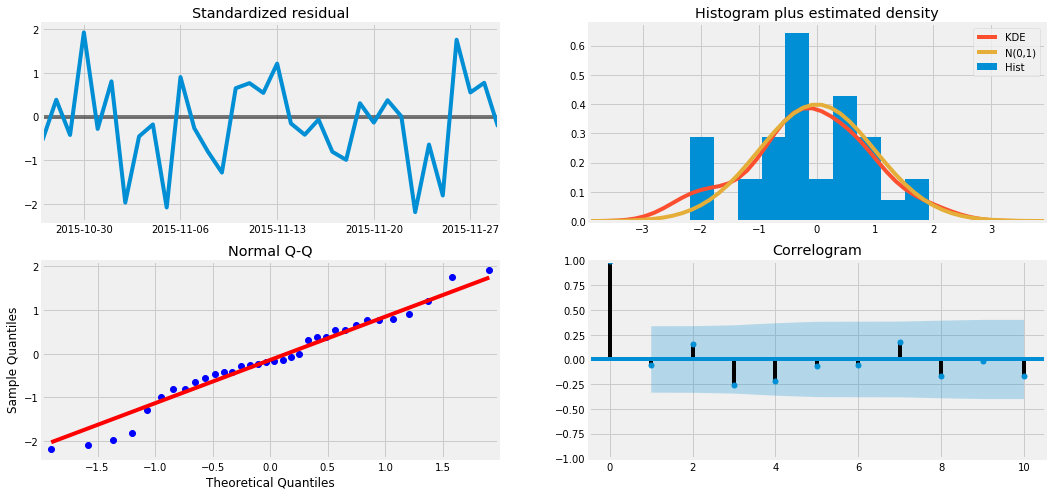

In [14]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Проверка прогноза и работы модели

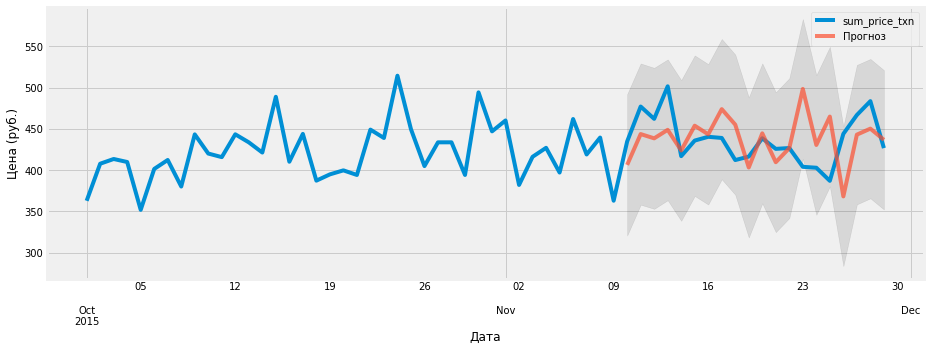

In [15]:
pred = results.get_prediction(start=pd.to_datetime('2015-11-10'), dynamic=False)
pred_ci = pred.conf_int()
ax = data['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Прогноз', alpha=.7, figsize=(14, 5))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Дата')
ax.set_ylabel('Цена (руб.)')
plt.legend()
plt.show()

Синий график показывает наблюдаемые значения по сравнению с скользящим прогнозом. Прогноз и факт имеют отклонения тольк в период с 23 ноября по 25 ноября, а целом они согласуются.

In [16]:
y_forecasted = pred.predicted_mean.to_frame().reset_index()[0]
y_truth = data['2015-11-10':].reset_index()['sum_price_txn']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('Среднеквадратичная ошибка  {}'.format(round(mse, 2)))

print('Квадратный корень из среднеквадратичной ошибки {}'.format(round(np.sqrt(mse), 2)))

Среднеквадратичная ошибка  1625.43
Квадратный корень из среднеквадратичной ошибки 40.32


### Прогнозирование средней цены на следующие 10 дней

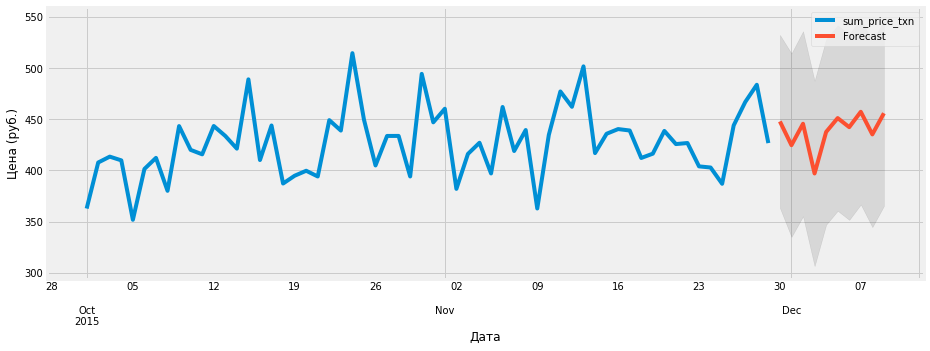

In [17]:
pred_uc = results.get_forecast(steps=10)
pred_ci = pred_uc.conf_int()
ax = data.plot(label='observed', figsize=(14, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Дата')
ax.set_ylabel('Цена (руб.)')
plt.legend()
plt.show()

Прогноз средней цены чека на 30 ноября 2015 года (нижнее и верхнее значение)

In [18]:
results.get_forecast(steps=1).conf_int()

,lower sum_price_txn,upper sum_price_txn
2015-11-30,363.380214,532.340283


Прогноз средней цены чека на 30 ноября 2015 года

In [19]:
pred_uc.predicted_mean[0]

447.86024848301224

### Получение прогнозов средней цены чека, среднего кол-ва чеков, а также средних продаж для каждого магазина на 30 ноября 2015 года

In [20]:
#функция подсчета будующих значений (цены, кол-ва на 30.11.2015)

def future_price_only(data):

    data = data.set_index('DAY')
    data.index = pd.to_datetime(data.index)

    #подбор параметров
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    for param in pdq:
        get=[]
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                get.append([results.aic,param, param_seasonal])

            except:
                    continue

    mod = sm.tsa.statespace.SARIMAX(data,
                                    order=min(get)[1],
                                    seasonal_order=min(get)[2],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    
    pred_uc = results.get_forecast(steps=1)
    pred_ci = pred_uc.conf_int()
    res = pred_uc.predicted_mean  
    return(res[0])

In [35]:
list_store = list(txn.STORE.unique())

Вычислим по каждому магазину будущую цену среднего чек магазина, среднего кол-ва чеков на 1 магазин в день, среднее число продаж на 1 магазин в день

In [36]:
#таблица с расчитанными значениями средней цены чека на 1 магазин за 30.11.2015
store_1_mean_txn = []

for id_store in list_store:
    store_1 = txn[(txn['STORE']==id_store)]
    store_mean_txn = store_1[['DAY','TXN','sum_price_txn']].drop_duplicates()
    store_mean_txn =  store_mean_txn.groupby(['DAY'])['sum_price_txn'].mean().reset_index()
    store_1_mean_txn.append([id_store, future_price_only(store_mean_txn)])

In [37]:
pd.DataFrame(data=store_1_mean_txn, index=None, columns = \
             ['Магазин' , 'Средняя цена чека на 30 нояб. (руб.)'], dtype=None, copy=False)

,Магазин,Средняя цена чека на 30 нояб. (руб.)
0,22691,284.782299
1,20581,314.056690
2,1574,194.927512
3,1602,251.450613
4,1579,349.935820
5,29245,278.352740
6,19009,259.124004
7,21761,266.513526
8,17474,329.205525
9,1544,332.098143


In [38]:
#таблица с расчитанными значениями среднего кол-ва чеков на 1 магазин за 30.11.2015
store_1_count_txn = []

for id_store in list_store:
    store_1 = txn[(txn['STORE']==id_store)]
    store_mean_txn = store_1[['DAY','TXN']].drop_duplicates()
    store_mean_txn =  store_mean_txn.groupby(['DAY'])['TXN'].count().reset_index()
    store_1_count_txn.append([id_store, future_price_only(store_mean_txn).round()])

In [39]:
pd.DataFrame(data=store_1_count_txn, index=None, columns = \
             ['Магазин' , 'Среднее кол-во чеков на 30 нояб. (штук)'], dtype=None, copy=False)

,Магазин,Среднее кол-во чеков на 30 нояб. (штук)
0,22691,545.0
1,20581,360.0
2,1574,317.0
3,1602,415.0
4,1579,647.0
5,29245,385.0
6,19009,718.0
7,21761,841.0
8,17474,957.0
9,1544,411.0


In [40]:
#таблица с расчитанными значениями среднего числа продаж на 1 магазин за 30.11.2015
store_1_count_art = []

for id_store in list_store:
    store_1 = txn[(txn['STORE']==id_store)]
    store_mean_txn = store_1[['DAY','ART']].drop_duplicates()
    store_mean_txn =  store_mean_txn.groupby(['DAY'])['ART'].count().reset_index()
    store_1_count_art.append([id_store, future_price_only(store_mean_txn).round()])

In [41]:
pd.DataFrame(data=store_1_count_art, index=None, columns = \
             ['Магазин' , 'Среднее число продаж на 30 нояб. (штук)'], dtype=None, copy=False)

,Магазин,Среднее число продаж на 30 нояб. (штук)
0,22691,1052.0
1,20581,856.0
2,1574,641.0
3,1602,872.0
4,1579,1194.0
5,29245,815.0
6,19009,1149.0
7,21761,1350.0
8,17474,1610.0
9,1544,912.0
